In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [15]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow.keras.layers
import tensorflow.keras.models
import tensorflow.keras.optimizers
import tensorflow.keras.datasets

### Data

In [16]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
x_train_orig = train.drop('label', 1).copy().to_numpy()
y_train = train[['label']].to_numpy()
x_test_orig = test.copy().to_numpy()
x_train_orig.shape, y_train.shape, x_test_orig.shape

((42000, 784), (42000, 1), (28000, 784))

## Encoder

In [17]:
# Encoder
x = tensorflow.keras.layers.Input(shape=(784), name="encoder_input")

encoder_dense_layer1 = tensorflow.keras.layers.Dense(units=300, name="encoder_dense_1")(x)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_dense_layer1)

encoder_dense_layer2 = tensorflow.keras.layers.Dense(units=2, name="encoder_dense_2")(encoder_activ_layer1)
encoder_output = tensorflow.keras.layers.LeakyReLU(name="encoder_output")(encoder_dense_layer2)

encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")
encoder.summary()

Model: "encoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 784)]             0         
_________________________________________________________________
encoder_dense_1 (Dense)      (None, 300)               235500    
_________________________________________________________________
encoder_leakyrelu_1 (LeakyRe (None, 300)               0         
_________________________________________________________________
encoder_dense_2 (Dense)      (None, 2)                 602       
_________________________________________________________________
encoder_output (LeakyReLU)   (None, 2)                 0         
Total params: 236,102
Trainable params: 236,102
Non-trainable params: 0
_________________________________________________________________


## Decoder

In [18]:
# Decoder
decoder_input = tensorflow.keras.layers.Input(shape=(2), name="decoder_input")

decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=300, name="decoder_dense_1")(decoder_input)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_dense_layer1)

decoder_dense_layer2 = tensorflow.keras.layers.Dense(units=784, name="decoder_dense_2")(decoder_activ_layer1)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_dense_layer2)

decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
decoder_dense_1 (Dense)      (None, 300)               900       
_________________________________________________________________
decoder_leakyrelu_1 (LeakyRe (None, 300)               0         
_________________________________________________________________
decoder_dense_2 (Dense)      (None, 784)               235984    
_________________________________________________________________
decoder_output (LeakyReLU)   (None, 784)               0         
Total params: 236,884
Trainable params: 236,884
Non-trainable params: 0
_________________________________________________________________


## AutoEncoder defintion

In [19]:
# Autoencoder
ae_input = tensorflow.keras.layers.Input(shape=(784), name="AE_input")
ae_encoder_output = encoder(ae_input)
ae_decoder_output = decoder(ae_encoder_output)

ae = tensorflow.keras.models.Model(ae_input, ae_decoder_output, name="AE")
ae.summary()

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
AE_input (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
encoder_model (Functional)   (None, 2)                 236102    
_________________________________________________________________
decoder_model (Functional)   (None, 784)               236884    
Total params: 472,986
Trainable params: 472,986
Non-trainable params: 0
_________________________________________________________________


## Model

In [20]:
# AE Compilation
ae.compile(loss="mse", optimizer=tensorflow.keras.optimizers.Adam(lr=0.0005))

# Preparing MNIST Dataset
x_train_orig = x_train_orig.astype("float32") / 255.0
x_test_orig = x_test_orig.astype("float32") / 255.0

x_train = np.reshape(x_train_orig, newshape=(x_train_orig.shape[0], np.prod(x_train_orig.shape[1:])))
x_test = np.reshape(x_test_orig, newshape=(x_test_orig.shape[0], np.prod(x_test_orig.shape[1:])))

# Training AE
ae.fit(x_train, x_train, epochs=150, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

encoded_images = encoder.predict(x_train)
decoded_images = decoder.predict(encoded_images)
decoded_images_orig = np.reshape(decoded_images, newshape=(decoded_images.shape[0], 28, 28))

Epoch 1/150
165/165 [==============================] - 3s 18ms/step - loss: 0.0700 - val_loss: 0.0558
Epoch 2/150
165/165 [==============================] - 3s 16ms/step - loss: 0.0555 - val_loss: 0.0543
Epoch 3/150
165/165 [==============================] - 3s 16ms/step - loss: 0.0541 - val_loss: 0.0533
Epoch 4/150
165/165 [==============================] - 3s 16ms/step - loss: 0.0531 - val_loss: 0.0525
Epoch 5/150
165/165 [==============================] - 3s 16ms/step - loss: 0.0524 - val_loss: 0.0517
Epoch 6/150
165/165 [==============================] - 3s 16ms/step - loss: 0.0517 - val_loss: 0.0511
Epoch 7/150
165/165 [==============================] - 3s 16ms/step - loss: 0.0511 - val_loss: 0.0506
Epoch 8/150
165/165 [==============================] - 3s 17ms/step - loss: 0.0504 - val_loss: 0.0502
Epoch 9/150
165/165 [==============================] - 3s 16ms/step - loss: 0.0501 - val_loss: 0.0499
Epoch 10/150
165/165 [==============================] - 3s 16ms/step - loss: 0.049

## Visualizations

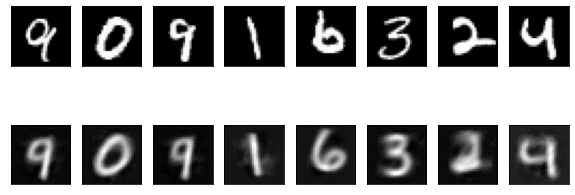

In [21]:
num_images_to_show = 8
plt.rcParams["figure.figsize"] = (10,4)
np.random.seed(0)
for im_ind in range(num_images_to_show):
    plot_ind = im_ind*2 + 1
    rand_ind = np.random.randint(low=0, high=x_train.shape[0])
    ax = plt.subplot(2, num_images_to_show, im_ind + 1)
    plt.imshow(x_train_orig[rand_ind, :].reshape(28,28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, num_images_to_show, im_ind + 1 + num_images_to_show)
    plt.imshow(decoded_images_orig[rand_ind, :, :], cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

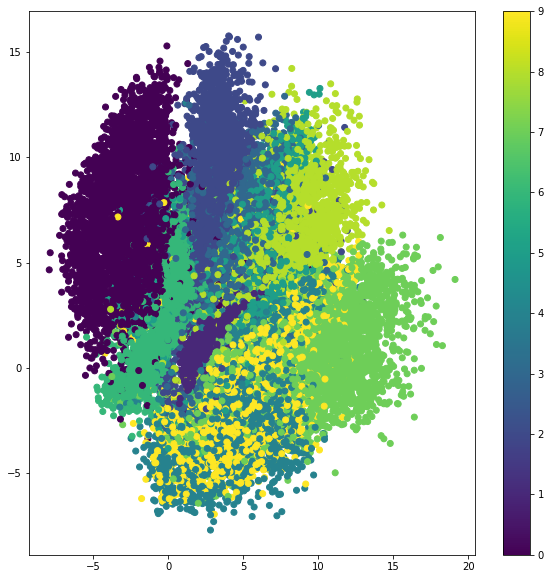

In [22]:
plt.rcParams["figure.figsize"] = (10,10)    
plt.figure()
plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=y_train)
plt.colorbar()

## Prediction using Encoded images

In [24]:
ae.predict(x_train).shape

(42000, 784)